# Anime Face Generation

##CNGAN

Configuration:

In [40]:
#hyperparameters
LATENT_DIM = 100
IMAGE_SIZE = 64
BATCH_SIZE = 128
NUM_EPOCHS = 1
LEARNING_RATE = 0.0002
BETA1 = 0.5
BETA2 = 0.999
NUM_WORKERS = 2

##Downloading the data...

In [41]:
import torch, torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch import nn, optim
from torchvision.utils import make_grid
from torchvision.utils import save_image
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image
import kaggle

%matplotlib inline
def show_images(images, nmax=IMAGE_SIZE):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
def download_data():
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files('splcher/animefacedataset', path='./', unzip=True)

download_data()

root = './faces/images/'

Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset


## Display random 10 images

In [42]:

from PIL import Image
import glob
image_list = []
rows = []
for filename in glob.glob('./images/*.jpg'):
    im=Image.open(filename)
    rows.append([filename])
    image_list.append(filename)

print(len(image_list))

63565


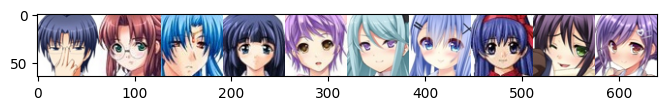

In [43]:
def gallery(array, ncols=8):
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

from PIL import Image
import random
import numpy as np

display_no_images = 10
def make_array():

    arr = []
    target_size = (IMAGE_SIZE, IMAGE_SIZE)
    # Randomly select display_no_images images to visualize
    for i in range(display_no_images):
        random_image_path = random.choice(image_list)
        # Open image, convert to RGB, resize, then convert to numpy array
        img = Image.open(random_image_path).convert('RGB')
        img_resized = img.resize(target_size) # Resize the image
        arr.append(np.asarray(img_resized))
    return np.array(arr)

array = make_array()
result = gallery(array, display_no_images)
plt.figure(figsize=(8,8))
plt.imshow(result)
plt.show()

## Pre-process and Load the Data


In [44]:
df = pd.DataFrame(rows)
df.to_csv('data.csv', index=False, header = None)

In [45]:
stats = (BETA1, BETA1, BETA1), (BETA1, BETA1, BETA1)
transform = transforms.Compose([
                                transforms.CenterCrop(IMAGE_SIZE),
                                transforms.Resize(IMAGE_SIZE, interpolation=2),
                                transforms.ToTensor(),
                                transforms.Normalize(*stats)])
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

class AnimeData(Dataset):
    """
    Wrap the data into a Dataset class, and then pass it to the DataLoader
    :__init__: Initialization data
    :__getitem__: support the indexing such that dataset[i] can be used to get ith sample
    :__len__: return the size of the dataset.
    """
    def __init__(self, root, transform=None):
        self.frame = pd.read_csv(root, header=None)
        self.transform = transform


    def __len__(self):
        return len(self.frame)


    def __getitem__(self, index):
        image_name = self.frame.iloc[index, 0]
        image = Image.open(image_name)
        image = self.transform(image)
        return image
trainset = AnimeData(root='./data.csv', transform=transform)
trainloader = DataLoader(trainset, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

## Chose between GPU or CPU

In [46]:
if torch.cuda.is_available():
    device=torch.device('cuda')
else:
    device=torch.device('cpu')

## Define a GAN
Configure GAN:
### Discriminator


In [47]:
class Discriminator(nn.Module):
    def __init__(self,inchannels):
        super(Discriminator,self).__init__()
        """
        Initialize the Discriminator Module
        :param inchannels: The depth of the first convolutional layer
        """
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=IMAGE_SIZE, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(IMAGE_SIZE),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(in_channels=IMAGE_SIZE, out_channels=2*IMAGE_SIZE, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(2*IMAGE_SIZE),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(in_channels=2*IMAGE_SIZE, out_channels=3*IMAGE_SIZE, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(2*IMAGE_SIZE),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(in_channels=3*IMAGE_SIZE, out_channels=4*IMAGE_SIZE, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(4*IMAGE_SIZE),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(in_channels=4*IMAGE_SIZE, out_channels=1, kernel_size=4, stride=2, padding=0),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self,x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network
        :return: Discriminator logits; the output of the neural network
        """
        x = self.conv_block1(x)
        return x

D=Discriminator(3).to(device)

## Generator


torch.Size([128, 3, 64, 64])


  0%|          | 0/497 [00:00<?, ?it/s]

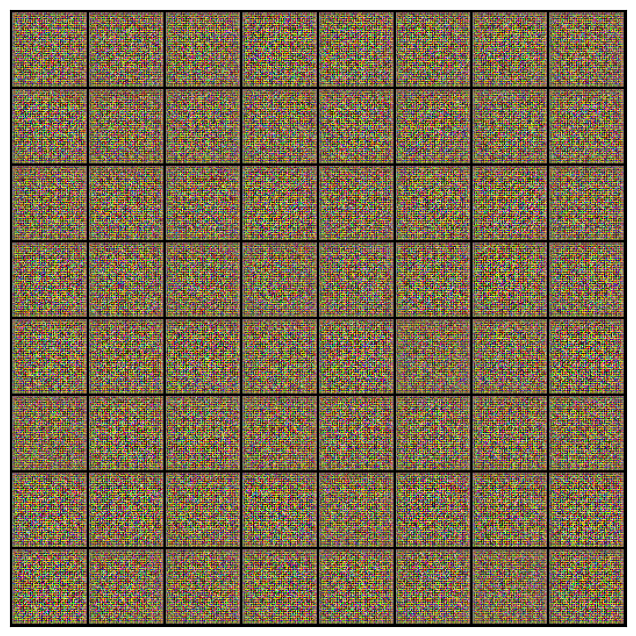

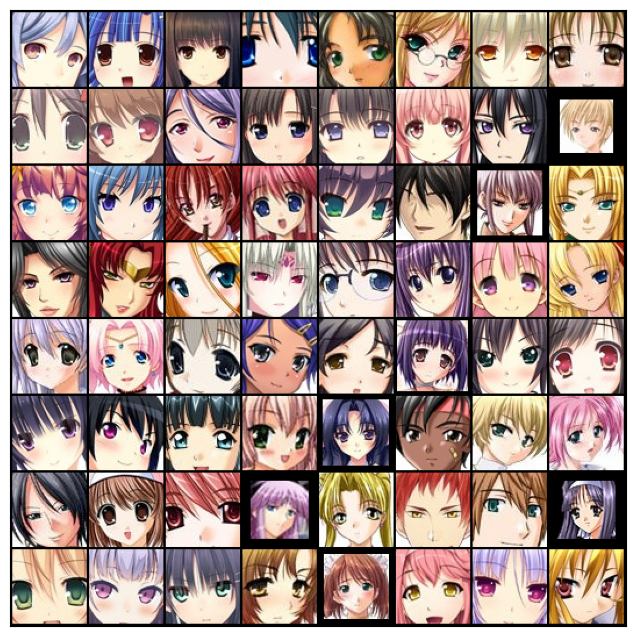

In [48]:
class Generator(nn.Module):
    def __init__(self,latent_size):
        super(Generator,self).__init__()
        """
        Initialize the Generator Module
        :param latent_size: The length of the input latent vector
        """
        self.conv_block1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=latent_size, out_channels=4*IMAGE_SIZE, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(4*IMAGE_SIZE),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=4*IMAGE_SIZE, out_channels=3*IMAGE_SIZE, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(3*IMAGE_SIZE),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=3*IMAGE_SIZE, out_channels=2*IMAGE_SIZE, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(2*IMAGE_SIZE),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=2*IMAGE_SIZE, out_channels=IMAGE_SIZE, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(IMAGE_SIZE),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=IMAGE_SIZE, out_channels=3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self,x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network
        :return: A 3x64x64 Tensor image as output
        """
        x = self.conv_block1(x)
        return x


G=Generator(LATENT_DIM).to(device)
# random latent tensors
noise = torch.randn(BATCH_SIZE, LATENT_DIM, 1, 1)

fake_images = G(noise)
print(fake_images.shape)

show_images(fake_images)

for real_images in tqdm(trainloader):
    real_images=(real_images).to(device)

show_images(real_images)

---
## Discriminator and Generator Losses

Calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`.
* the discriminator outputs 1 for real images and 0 for fake images

### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.



In [49]:
loss_fn = torch.nn.MSELoss()
def Real_loss(preds,targets):
    '''
       Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss
    '''
    beta_distr = torch.distributions.beta.Beta(1,5,validate_args=None)
    label_noise = beta_distr.sample(sample_shape=targets.shape).to(torch.device(device))
    loss= loss_fn(targets,preds-label_noise)
    return loss
def Fake_loss(preds,targets):
    '''
       Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss
    '''
    beta_distr = torch.distributions.beta.Beta(1,5,validate_args=None)
    label_noise = beta_distr.sample(sample_shape=targets.shape).to(torch.device(device))
    loss= loss_fn(targets,preds+label_noise)
    return loss

## Optimizers


Define optimizers models with appropriate hyperparameters.

In [50]:
# Create optimizers for the discriminator D and generator G
opt_d = optim.Adam(D.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
opt_g = optim.Adam(G.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))

### Save the generated images

In [51]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)
def save_samples(index, latent_tensors, generator, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
        plt.show()
fixed_latent = torch.randn(IMAGE_SIZE, LATENT_DIM, 1, 1, device=device)

## Training GAN to generate anime faces
Training will involve alternating between training the discriminator and the generator. Functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.


In [53]:
# Complete the training function
losses_g = []
losses_d = []
real_scores = []
fake_scores = []
def train(D, G, d_optimizer, g_optimizer, epochs=1):
    iter_count = 0
    start_idx=1
    for epoch in range(epochs):
        for real_images in tqdm(trainloader):
            real_images=real_images.to(device)
            # Pass real images through discriminator
            D_out_real = D(real_images)
            label_real = torch.full(D_out_real.shape, 1.0).to(torch.device(device))
            real_loss = Real_loss(label_real,D_out_real)
            real_score = torch.mean(D_out_real).item()

            # Generate fake images
            noise = torch.randn(BATCH_SIZE, LATENT_DIM, 1, 1).to(torch.device(device))
            fake_images =  G(noise)

            # Pass fake images through discriminator
            D_out_fake = D(fake_images)
            label_fake =  torch.full(D_out_fake.shape, 0).to(torch.device(device))
            fake_loss = Fake_loss(label_fake, D_out_fake)
            fake_score = torch.mean(D_out_fake).item()

            # Update discriminator weights
            loss_d = real_loss + fake_loss

            d_optimizer.zero_grad()
            loss_d.backward(retain_graph = True)
            d_optimizer.step()

            # Generate fake images
            noise2 = torch.randn(BATCH_SIZE, LATENT_DIM, 1, 1).to(torch.device(device))
            fake_images2 =  G(noise2)

            gen_steps = 1
            for i in range(0, gen_steps ):
            # Try to fool the discriminator
                D_out_fake2 = D(fake_images2)

                # The label is set to 1(real-like) to fool the discriminator
                label_real1 = torch.full(D_out_fake2.shape, 1.0).to(torch.device(device))
                loss_g = Real_loss(label_real1, D_out_fake2)

                # Update generator weights
                g_optimizer.zero_grad()
                loss_g.backward(retain_graph = (i<gen_steps -1 ))
                g_optimizer.step()


        losses_g.append(loss_g.item())
        losses_d.append(loss_d.item())
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
        epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent,G, show=True)

        state_dis = {'dis_model': D.state_dict(), 'epoch': epoch}
        state_gen = {'gen_model': G.state_dict(), 'epoch': epoch}
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state_dis, 'checkpoint/'+'D__'+str(epoch+1)) #each epoch
        torch.save(state_gen, 'checkpoint/'+'G__'+str(epoch+1)) #each epoch
#Train the GAN
train(D,G,opt_d,opt_g,epochs=NUM_EPOCHS)

  0%|          | 0/497 [00:00<?, ?it/s]

RuntimeError: running_mean should contain 192 elements not 128

In [ ]:
##Visualize loss curve of D and G
fig, ax = plt.subplots()
plt.plot(losses_g, label='Discriminator', alpha=BETA1)
plt.plot(losses_d, label='Generator', alpha=BETA1)
plt.title("Training Losses")
plt.legend()